# Econometría Aplicada 1 (Taller) - Examen Final
Importar librerías

In [75]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Ejercicio 3: Índice hedónico de computadoras
Cargar datos

In [42]:
df = pd.read_csv('../dat/chow.txt', sep='\t')

### (a) Construcción de atributos
Crear los atributos necesarios

In [43]:
# Agregar término constante
df['CONST'] = 1

# Crear atributos logarítmicos
for col in ['RENT','MULT','ACCESS','ADD']:
    df['LN'+col] = np.log(df[col])
    
# Crear Memory Space
df['LNMEM'] = np.log(df[['WORDS','BINARY','DIGITS']].product(axis=1))

# Crear dummies por año (61, 62, ..., 65)
df['D'] = np.where(df['YEAR'].lt(61), 60, df['YEAR'])
df = pd.get_dummies(df, prefix='D', prefix_sep='_', columns=['D'], drop_first=True)

Comparación de matríces de correlación en los periodos
- [1954-1959]

In [44]:
c1 = df.loc[df['YEAR'].between(54,59), 'LNRENT':'LNMEM'].corr()
c1.round(2)

,LNRENT,LNMULT,LNACCESS,LNADD,LNMEM
LNRENT,1.00,-0.87,-0.85,-0.84,0.88
LNMULT,-0.87,1.00,0.86,0.98,-0.74
LNACCESS,-0.85,0.86,1.00,0.85,-0.61
LNADD,-0.84,0.98,0.85,1.00,-0.73
LNMEM,0.88,-0.74,-0.61,-0.73,1.00


- [1960-1965]

In [45]:
c2 = df.loc[df['YEAR'].between(60,65), 'LNRENT':'LNMEM'].corr()
c2.round(2)

,LNRENT,LNMULT,LNACCESS,LNADD,LNMEM
LNRENT,1.00,-0.63,-0.58,-0.63,0.88
LNMULT,-0.63,1.00,0.77,0.94,-0.57
LNACCESS,-0.58,0.77,1.00,0.81,-0.46
LNADD,-0.63,0.94,0.81,1.00,-0.56
LNMEM,0.88,-0.57,-0.46,-0.56,1.00


Los coeficientes de correlación entre las siguientes variables cambiaron menos de 10 puntos porcentuales entre ambos periodos:
1. `LNRENT` y `LNMEM`
1. `LNMULT` y `LNACCESS`
1. `LNMULT` y `LNADD`
1. `LNACCESS` y `LNADD`

Los demás pares de variables cambian en 10 o más puntos porcentuales.

En general, ambas matríces de correlación se parecen. Sin embargo, considero que hay diferencias importantes entre ambos periodos. En particular, hay menos pares de variables con coeficientes de correlación mayores a 0.7 en valor absoluto en el segundo periodo.

Igualmente, creo que Chow estaba en lo correcto al preocuparse por la posibilidad de un problema de multicolinealidad, pues todos los pares de variables excepto por `LNMEM` y `LNACCESS` tienen un coeficiente de correlación de almenos 0.7 en valor absoluto en el periodo previo a 1960.

Las correlaciones siguen siendo altas de 1960 en adelante. Sin embargo, los coeficientes tienden a disminuir en esta ventana de tiempo.

### (b) Regresión de Chow

In [51]:
# Objetos para regresión
feats = ['CONST','D_61','D_62','D_63','D_64','D_65','LNMULT','LNMEM','LNACCESS']
targt = 'LNRENT'
X = df.loc[df['YEAR'].ge(60), feats]
y = df.loc[df['YEAR'].ge(60), targt]

# Modelo de Chow
m1 = sm.OLS(endog=y, exog=X)
m1_res = m1.fit()

In [59]:
print(m1_res.summary().tables[1])
print('Observations:', int(m1_res.nobs))
print('R2:', round(m1_res.rsquared, 3))

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CONST         -0.1045      0.315     -0.332      0.741      -0.732       0.523
D_61          -0.1398      0.166     -0.840      0.404      -0.472       0.192
D_62          -0.4891      0.174     -2.815      0.006      -0.835      -0.143
D_63          -0.5938      0.166     -3.575      0.001      -0.925      -0.263
D_64          -0.9248      0.166     -5.561      0.000      -1.256      -0.593
D_65          -1.1632      0.166     -7.003      0.000      -1.494      -0.832
LNMULT        -0.0654      0.028     -2.301      0.024      -0.122      -0.009
LNMEM          0.5793      0.035     16.369      0.000       0.509       0.650
LNACCESS      -0.1406      0.029     -4.794      0.000      -0.199      -0.082
Observations: 82.0
R2: 0.908


Índice de precios usando método alternativo

In [73]:
t = pd.concat([pd.Series([1], ['D_60']), np.exp(m1_res.params['D_61':'D_65'])]).to_frame()
t.columns=['Price Index (exp)']
t['Price Index (Chow)'] = [1,.8438,.6414,.5330,.3906,.3188]
t.round(4)

,Price Index (exp),Price Index (Chow)
D_60,1.0000,1.0000
D_61,0.8695,0.8438
D_62,0.6132,0.6414
D_63,0.5522,0.5330
D_64,0.3966,0.3906
D_65,0.3125,0.3188


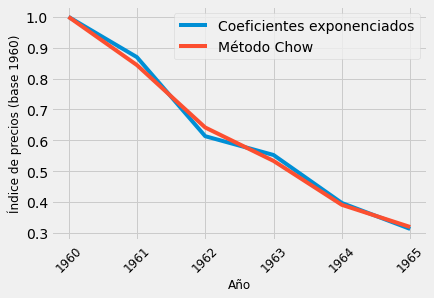

In [82]:
plt.plot(t.index, t['Price Index (exp)'], label='Coeficientes exponenciados')
plt.plot(t.index, t['Price Index (Chow)'], label='Método Chow')
plt.xticks(t.index, labels=range(1960,1966), rotation=45, fontsize=12)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Índice de precios (base 1960)', fontsize=12)
plt.legend()
plt.show()

El índice de precios usando el método de exponenciar los coeficientes de efectos fijos por año da resultados muy similares al método de Chow. Ambas series muestran la misma tendencia a la baja y las diferencias son negligibles.

### (c) Especificación alternativa
Prueba de que la especificación de Chow asume que el logaritmo `BINARY * DIGITS` y de `WORDS` tienen la misma pendiente:
$$\beta \ln(MEM) = \beta \ln(WORDS \times BINARY \times DIGITS) = \beta \ln(WORDS) + \beta \ln(BINARY \times DIGITS)$$

In [97]:
# Separar LNMEM en dos términos independientes
df = df.assign(LNLENGTH=np.log(df['BINARY'].multiply(df['DIGITS'])),
               LNWORDS=np.log(df['WORDS']))

# Objetos para regresión
feats = ['CONST','D_61','D_62','D_63','D_64','D_65','LNMULT','LNLENGTH','LNWORDS','LNACCESS']
X = df.loc[df['YEAR'].ge(60), feats]
y = df.loc[df['YEAR'].ge(60), 'LNRENT']

# Modelo alternativo
m2 = sm.OLS(y, X)
m2_res = m2.fit()
print(m2_res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CONST          0.0257      0.352      0.073      0.942      -0.677       0.728
D_61          -0.1562      0.168     -0.930      0.355      -0.491       0.179
D_62          -0.4990      0.175     -2.859      0.006      -0.847      -0.151
D_63          -0.6004      0.167     -3.603      0.001      -0.933      -0.268
D_64          -0.9289      0.167     -5.571      0.000      -1.261      -0.597
D_65          -1.1722      0.167     -7.027      0.000      -1.505      -0.840
LNMULT        -0.0701      0.029     -2.414      0.018      -0.128      -0.012
LNLENGTH       0.5334      0.066      8.120      0.000       0.402       0.664
LNWORDS        0.5896      0.038     15.699      0.000       0.515       0.664
LNACCESS      -0.1320      0.031     -4.240      0.000      -0.194      -0.070


Probar si los coeficientes son distintos entre sí:

In [98]:
print('R2 adj de modelo 1:', round(m1_res.rsquared_adj, 4))
print('R2 adj de modelo 2:', round(m1_res.rsquared_adj, 4))

# Probar si los coeficientes son distintos
m2_res.t_test([0,0,0,0,0,0,0,1,-1,0]).summary()

R2 adj de modelo 1: 0.8984
R2 adj de modelo 2: 0.8984


,coef,std err,t,P>|t|,[0.025,0.975]
c0,-0.0562,0.068,-0.831,0.409,-0.191,0.079


Ambas especificaciones resultan en prácticamente el mismo coeficiente $R^2$ adjustado, así que la especificación no tienen un impacto sobre el desempeño predictivo del modelo. Sin embargo, los coeficientes de `LNLENGTH` y de `LNWORDS` son muy parecidos y no podemos rechazar la hipótesis nula de que tengan el mismo efecto sobre la variable dependiente.

Por cuestiones de parsimonía, prefiero el primer modelo.

### (d) Efectos fijos sin término constante
Usar todas las observaciones y crear efectos fijos por año (sin constante)

In [110]:
# Objetos para regresión
X = pd.concat([pd.get_dummies(df['YEAR'], prefix='D'), df[['LNMULT','LNMEM','LNACCESS']]], axis=1)
y = df['LNRENT']

# Modelo
m3 = sm.OLS(y, X)
m3_res = m3.fit()
print(m3_res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D_54           1.3931      0.288      4.829      0.000       0.822       1.964
D_55           1.3385      0.290      4.614      0.000       0.764       1.913
D_56           1.1808      0.294      4.021      0.000       0.599       1.762
D_57           1.1086      0.296      3.742      0.000       0.522       1.695
D_58           0.9171      0.274      3.347      0.001       0.375       1.460
D_59           0.6990      0.274      2.555      0.012       0.157       1.241
D_60           0.2542      0.263      0.967      0.336      -0.266       0.775
D_61           0.1542      0.267      0.577      0.565      -0.374       0.683
D_62          -0.2287      0.242     -0.946      0.346      -0.707       0.250
D_63          -0.3395      0.233     -1.459      0.147      -0.800       0.121
D_64          -0.6351      0.235     -2.702      0.0

In [128]:
t = np.exp(m3_res.params['D_54':'D_65'] - m3_res.params['D_54']).to_frame()
t.columns = ['Price Index (base 1954)']
t['Price Index (base 1965)'] = t['Price Index (base 1954)'].div(t.loc['D_65'].item())
(t * 100).round(0)

,Price Index (base 1954),Price Index (base 1965)
D_54,100.0,1003.0
D_55,95.0,950.0
D_56,81.0,811.0
D_57,75.0,755.0
D_58,62.0,623.0
D_59,50.0,501.0
D_60,32.0,321.0
D_61,29.0,291.0
D_62,20.0,198.0
D_63,18.0,177.0


La segunda columna es igual a la primera salvo porque renormalicé la serie a 1965.

Con respecto a la serie de Triplett, mis estimaciones resultan en índices más bajos. Por ejemplo, en 1954, el precio de una computadora era 10 veces el índice de 1965. De acuerdo a los coeficientes estimados por Triplett, el precio de la misma computadora era 13.20 veces el precio de 1965.

### (e) Heteroscedasticidad

In [166]:
# Objetos para regresión
w = np.sqrt(df.loc[df['YEAR'].ge(60), 'VOLUME'])
X = df.loc[df['YEAR'].ge(60), m1.exog_names]
y = df.loc[df['YEAR'].ge(60), 'LNRENT']

# Modelo
m4 = sm.OLS(y, X.multiply(w, axis=0), hasconst=True)
m4_res = m4.fit()
print(m4_res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CONST          0.2270      0.285      0.796      0.429      -0.342       0.795
D_61          -0.1369      0.133     -1.030      0.307      -0.402       0.128
D_62           0.0544      0.211      0.257      0.798      -0.367       0.476
D_63          -0.0633      0.113     -0.558      0.578      -0.289       0.163
D_64          -0.1822      0.138     -1.318      0.192      -0.458       0.093
D_65          -0.4108      0.122     -3.362      0.001      -0.654      -0.167
LNMULT        -0.0762      0.024     -3.190      0.002      -0.124      -0.029
LNMEM          0.1204      0.032      3.771      0.000       0.057       0.184
LNACCESS       0.0203      0.027      0.751      0.455      -0.034       0.074


Me parece que este método no es correcto porque el libro muestra un ejemplo donde $Y_i$ es el precio promedio del modelo $i$ en la siguiente especificación:
$$Y_i = \beta_0 + \beta_1 X_{1,i} + ... + u_i$$

Nuestra especificación usa $\ln(Y_i)$ como variable dependiente, la cual no es una transformación lineal. Es decir, $\sqrt{S_m} \ \times \ln(Y_i) \neq \ln\big(Y_i \times \sqrt{S_m} \ \big)$.

Solo deberíamos de aplicar esta transformación cuando modelamos el precio de las computadoras, no el logaritmo del precio.

Como se muestra a continuación, el método que no usa este atajo coincide casi puntualmente con la estimación original salvo que los errores estándar son más grandesPara probar, voy a usar el método integrado en Python.

In [167]:
m5 = sm.OLS(y, X, weights=w).fit()
print(m5.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CONST         -0.1045      0.315     -0.332      0.741      -0.732       0.523
D_61          -0.1398      0.166     -0.840      0.404      -0.472       0.192
D_62          -0.4891      0.174     -2.815      0.006      -0.835      -0.143
D_63          -0.5938      0.166     -3.575      0.001      -0.925      -0.263
D_64          -0.9248      0.166     -5.561      0.000      -1.256      -0.593
D_65          -1.1632      0.166     -7.003      0.000      -1.494      -0.832
LNMULT        -0.0654      0.028     -2.301      0.024      -0.122      -0.009
LNMEM          0.5793      0.035     16.369      0.000       0.509       0.650
LNACCESS      -0.1406      0.029     -4.794      0.000      -0.199      -0.082
